# Introduction to Kernel Density Estimation (KDE)


**Objectives:** 
- To understand exactly what a kernel density estimate is approximating.
- To understand the parameters that affecct the performance of a KDE.


## 1. Problem Setup.
We need the following notation:
- $f$ is an underlying probability distribution function (pdf) for a probability distribution $\mathcal{D}$.
- Samples $x_i$ are drawn independently and identically from the distribution $\mathcal{D}$.

The high-level aim of KDE is to use a smoothing function, known as the _kernel function_, $K$, to estimate the function $f$.

The _kernel density estimator_ is the function $\hat{f}$.  It is evaluated at a test (or query) point $x^*$ and satisfies the following relationship:
\begin{align}
f(x^*) \star K(x^*) &= \int_{\text{domain}(f)} K(x^* - x) f(x) dx \\
&= \mathbf{E}_{f(x)} \left[ K(x^* - x) \right] \\ 
&\approx \frac1n \sum_{i=1}^n K(x^* - x_i) \\ 
&= \hat{f}(x^*).
\end{align}

In words, the KDE at $x^*$ is approximately equal to the convolution of the density at $x^*$ with the kernel at $x^*$.

Notably, this _does not_ mean that the KDE $\hat{f}$ is necessarily a good estimator for the probability density function, despite that being the motivation for the estimation problem.

## 2. Initial Comparison

We will investigate this estimation of $\hat{f}(x^*) \approx f(x^*) \star K(x^*)$.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import scipy.integrate as integrate
from scipy.spatial.distance import cdist
%matplotlib inline

In [41]:
import warnings
warnings.filterwarnings('ignore')

First, we will consider the case when the distribution of study is the standard normal distribution $N(0,1)$.  We also obtain a _sample_ of points from $N(0,1)$.

In [2]:
n_sample = 10000
Z = stats.norm(0, 1)
X_train = Z.rvs(size=n_sample)[:, np.newaxis]

The distribution is plotted below along with the samples.  

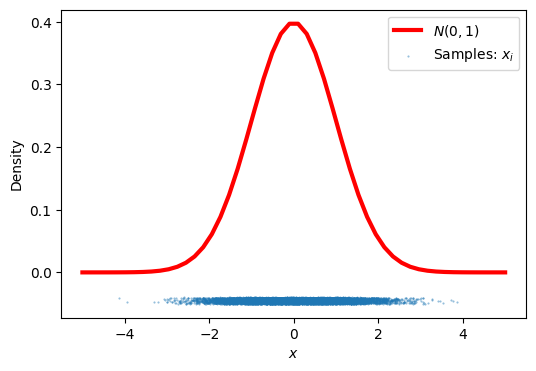

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
_x = np.linspace(-5, 5)
ax.plot(_x, Z.pdf(_x), label=r"$N(0,1)$", color='red', lw=3.)
ax.scatter(X_train, 
           0.01*np.random.uniform(size=X_train.shape[0])-0.05, 
           marker='.',
           s=1.,
          alpha=0.5, label="Samples: $x_i$")
ax.set_ylabel("Density")
ax.set_xlabel(r"$x$")
ax.legend()

Next, we define a kernel function for single variable inputs which takes a free parameter $\gamma > 0$ that we may choose.

\begin{align}
K(u) = \exp(-\gamma u^2).
\end{align}

For multivariable inputs we use
\begin{align}
K(u) = \exp(-\gamma ||u||^2).
\end{align}

If we choose the constant $\gamma = 1 / 2 h^2$ for some $h$, then $K$ represents a Gaussian kernel provided that 
we return the following rescaled answer for the kernel density estimate:

\begin{align}
\hat{f}(x^*) = \frac{1}{h \sqrt{2\pi} }\frac1n \sum_{i=1}^n K(x^* - x_i).
\end{align}

In [4]:
def kernel_density(Xtrain, Xtest, bandwidth=1.):
    """
    Returns the kernel density estimate between Xtrain and Xtest.
    returns:
        (1/n)*(1/bandwidth*sqrt(2pi))^d*sum_{i=1}^n K( (x* - x_i) / bandwidth )
    The bandwidth in scipy is in the numerator so we use 1./bandwidth
    The mean function picks up the 1/n factor.
    """
    for x in [Xtrain, Xtest]:
        if x.ndim == 1:
            x.reshape(-1, 1)
    g = (1./bandwidth)**2
    K = np.exp(-cdist(Xtrain, Xtest, metric='sqeuclidean')*g/2)
    K *= 1./(bandwidth*np.sqrt(2*np.pi))**Xtrain.shape[1]
    return np.mean(K, axis=0)


Recall that we want to compare $\hat{f}$ to the convolution below at a test point $x^*$. 
Assumign that $h=1$ we have:

\begin{align}
f(x^*) \star K(x^*) &= \frac{1}{\sqrt{2\pi}}\int_{\text{domain}(f)} K(x^* - x) f(x) dx \\ 
&= \frac{1}{\sqrt{2\pi}} \int_{\text{domain}(f)} \exp\left(-\|x^* - x\|^2\right) f(x) dx
\end{align}

The convolution can be estimated through the following code.

In [5]:
x_test = 0.1
x_test_arr = np.array([x_test])[:, np.newaxis] # needed for some of the vectorised functions
pdf_x_test = Z.pdf(x_test)
print(f"Target: {pdf_x_test}")

Target: 0.3969525474770118


In [6]:
def convolution_at_q(x, q, h):
    return Z.pdf(x)*(np.exp(-0.5*np.linalg.norm((1./h)*(x - q))**2) / (h*np.sqrt(2*np.pi)))

# This function evaluates the convolution (f \star K) at x*
conv_estimate = integrate.quad(convolution_at_q, 
                                -np.inf, np.inf,
                                args=(x_test_arr, 1.))[0]

Let's do a quick check on the two quantities that we are comparing.

In [7]:
print(f"Convolution: {conv_estimate:.3f}")
print(f"KDE        : {kernel_density(X_train, x_test_arr)[0]:.3f}")

Convolution: 0.281
KDE        : 0.280


They are comparable, which is good news.  Now we will begin to experiment with this and check that the KDE method approaches the KDE value.

**Experimental Setup.**
We fix a number of trials: `num_trials` and choose a test point `query`.
We generate an independent sample/training set for every trial and obtain the two: one for convolution, one for using the KDE.

We will then plot the two error curves.

If this experiment is too slow then try varying the number of trials or using 
```
nn = np.linspace(100, 1000000, dtype=np.int64)
```

In [8]:
num_trials = 25
query = np.array([1.])[:, np.newaxis]
nn = np.logspace(2, 7, endpoint=False, dtype=np.int64, num=20) 

kernel_estimates = {i:np.zeros((len(nn),), dtype=float) for i in range(num_trials)}

conv_estimates = {i:np.zeros((len(nn),), dtype=float) for i in range(num_trials)}

for i,n in enumerate(nn):
    for t in range(num_trials):
        Xtrain = stats.norm(0, 1).rvs(size=n)[:, np.newaxis]
        estimate = kernel_density(Xtrain, query)[0]
        kernel_estimates[t][i] = estimate
        conv_estimates[t][i] = integrate.quad(convolution_at_q, -100., 100., args=(query,1.))[0]

In [9]:
kernel_df = pd.DataFrame.from_dict(kernel_estimates)
conv_df = pd.DataFrame.from_dict(conv_estimates)
error_df = kernel_df - conv_df
abs_error_df = error_df.abs()

First, we plot the error $\hat{f}(x^*) - f(x^*) \star K(x^*)$ versus the sample size, showing that as the sample size increases, the error decreases.  We plot the median and a $90\%$ confidence interval.

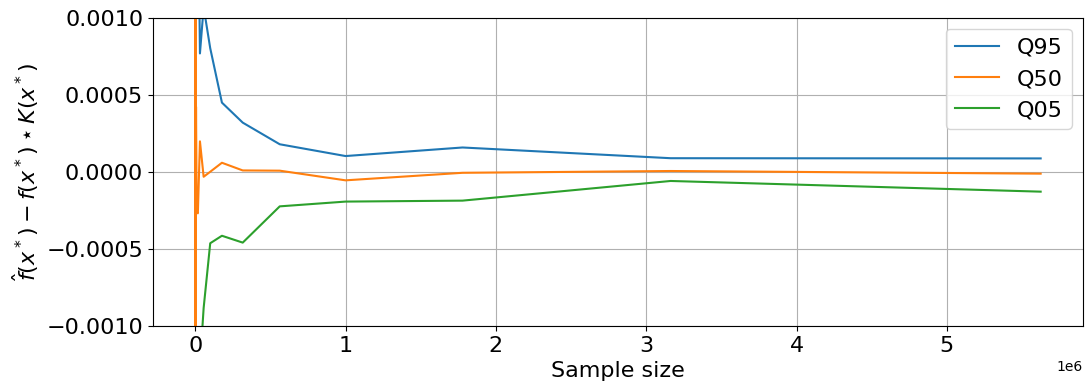

In [10]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(nn, error_df.quantile(q=0.95, axis=1), label='Q95')
ax.plot(nn, error_df.quantile(q=0.5, axis=1), label="Q50")
ax.plot(nn, error_df.quantile(q=0.05, axis=1), label='Q05')
ax.set_ylabel(r"$\hat{f}(x^*) - f(x^*) \star K(x^*)$")
ax.set_xlabel(r"Sample size")
ax.set_ylim(-0.001, 0.001)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.get_label().set_fontsize(16)
ax.yaxis.get_label().set_fontsize(16)
ax.legend(prop={'size': 16})

Once $n$ is moderately large, we see that the median concetrates about $0$ and we appear to over and under estimate the quantity with roughly equal proportion.  This suggests that the two quantities are close and $\hat{f}(x^*)$ is an unbiased estimation of  $f(x^*) \star K(x^*)$.  More trials would smooth out the curves.

However, we also want to understand the rate of convergence so we measure the absolute error.  The absolute error only tells us about the magnitude of the error, not the sign.

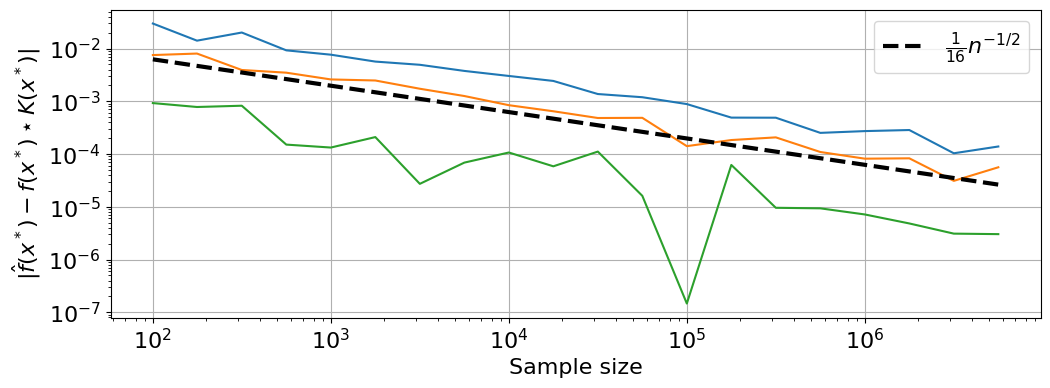

In [11]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(nn, abs_error_df.quantile(q=0.975,axis=1))
ax.plot(nn, abs_error_df.quantile(q=0.5, axis=1))
ax.plot(nn, abs_error_df.quantile(q=0.025,axis=1))
ax.plot(nn, (1/16)*(nn)**(-0.5),  linestyle='--', color='black', linewidth=3.0, label=r"$\frac{1}{16}n^{-1/2}$")
ax.set_ylabel(r"$|\hat{f}(x^*) - f(x^*) \star K(x^*)|$")
ax.set_xlabel(r"Sample size")
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.get_label().set_fontsize(16)
ax.yaxis.get_label().set_fontsize(16)
ax.legend(prop={'size': 16})

This plots show that we get convergence of the KDE to the convolution at a rate of about $1/\sqrt{n}$.  

### 2.1 Illustrating the KDE

Now that we have a handle on _what_ the KDE is approximating, let's illustrate the returned curve.
Again, we sample points from the normal distribution but now we also plot the KDE over a uniform test grid on $[-3,3]$.

Text(0.5, 0, 'x')

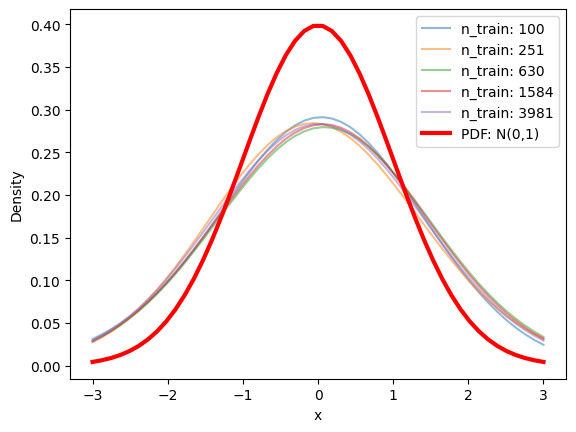

In [12]:
x_test = np.linspace(-3., 3.)[:, np.newaxis]
nn = np.logspace(2, 4, endpoint=False, dtype=np.int64, num=5) 

kernel_estimates = {i:np.zeros((len(nn),), dtype=float) for i in range(num_trials)}

conv_estimates = {i:np.zeros((len(nn),), dtype=float) for i in range(num_trials)}

fig, ax = plt.subplots()
for i,n in enumerate(nn):
    Xtrain = stats.norm(0, 1).rvs(size=n)[:, np.newaxis]
    estimate = kernel_density(Xtrain, x_test)
    ax.plot(x_test, estimate, alpha=0.5, color="C"+str(i), label=f"n_train: {n}")
ax.plot(x_test, stats.norm(0,1).pdf(x_test), lw=3.0, color='red', label="PDF: N(0,1)")    
ax.legend()
ax.set_ylabel("Density")
ax.set_xlabel("x")

The shape looks correct, as as expected from the preceding plots, we look to be converging to some curve similar to the distribution...*but didn't we want to estimate the underlying distribution function* itself?
Generally speaking, we only claim to estimate the density function over a sample, not the true underlying distribution.
However, if certain conditions are met then, as outlined in the next section, we also estimate the underlying distribution.


## 3. Bandwidth Selection

One detail that we have thus far omitted is the `bandwidth` parameter, $h$. 
This parameter $h$ controls the width of the kernels applied at every point. 
In general, it might be difficult to choose a priori the correct bandwidth.
If the bandwidth is chosen too small, then the returned curve will be too spiky, and if the bandwidth is too large, then the curve will appear too flat.

Suppose that we sample $(x_1, x_2, x_3) = (-2, 0.05, 0.15) $ from a standard normal distribution and fit a KDE model.
When we query a test point $x^*$, we are taking a sum over distances from $x^*$ to the points $x_1, x_2, x_3$.
Ignoring the constants, the KDE at $x^*$ is $\hat{f}(x^*) = K(x^* - x_1) + K(x^* - x_2) + K(x^* - x_3)$.
When a query point $x^*$ comes at test time, its distance is compared to all $x_i$ and (an amount proportional to) $\exp(-\frac{1}{2h^2} |x_i - x^*|^2)$ is contributed to $\hat{f}(x^*)$.  The contribution should be ''large'' when the distance is small and ''small'' when the distance is large.

In the plot below, the query point $x^*$ is close to the two points on the right hand side so picks up a non-trivial contribution from each.  On the other hand, it is far from the point on the left hand side, so the the exponential function makes this contribute almost zero to the overall sum.

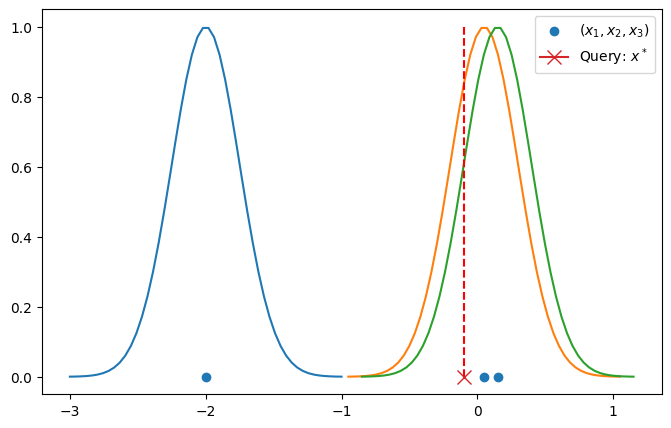

In [38]:
x_vals = [-2, 0.05, 0.15]
query = -0.1
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x_vals, np.zeros_like(x_vals), label=r"$(x_1, x_2, x_3)$")

h = 0.25
window = np.linspace(-1., 1.) 
for i, x in enumerate(x_vals):
    ax.plot(x+window, np.exp(-0.5*(window/h)**2))
ax.vlines(query, 0, 1., color='red', linestyle="--")
ax.plot(query, 0, label=r"Query: $x^*$", marker= 'x', markersize=10.)
ax.legend()

### Small $h$

When $h$ is too small, the kernels are extremely narrow (think of a Gaussian distribution with small variance).  Then any test point can easily lie in the tails of many of the kernel functions about each of the datapoints.  This means that the contribution is small from almost all of the sample data.  However, when a test point lies close to a sample point, it gets essentially the entirety of its contribution to $\hat{f}$ from that datapoint, so we see large spikes in the returned KDE.

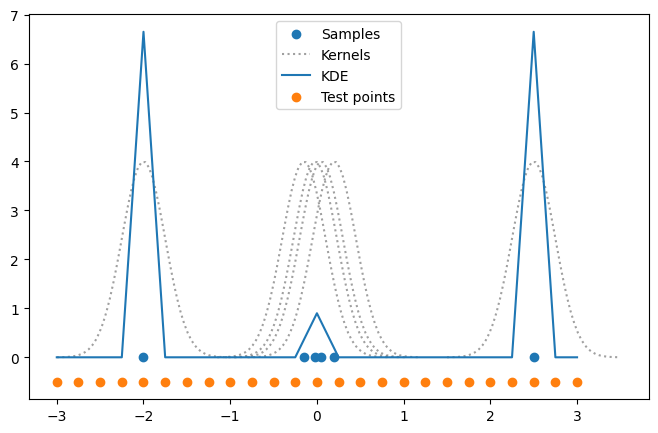

In [14]:
x_vals = [-2, -0.15, -0.02, 0.05, 0.2, 2.5]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x_vals, np.zeros_like(x_vals), label='Samples')

h = 0.25
window = np.linspace(-1., 1.) 
for i, x in enumerate(x_vals):
    if i == 0:
        ax.plot(x+window, np.exp(-0.5*(window/h)**2)/h, alpha=0.75, linestyle=":", color='grey', label="Kernels")
    else:
        ax.plot(x+window, np.exp(-0.5*(window/h)**2)/h, alpha=0.75, linestyle=":", color='grey')
    
test_points = np.linspace(-3, 3, 25)[:, np.newaxis]
kde = kernel_density(np.array(x_vals)[:, np.newaxis], test_points, 0.01)
ax.plot(test_points, kde, label="KDE")
ax.scatter(test_points, -0.5*np.ones_like(test_points), label="Test points")
ax.legend()

### Large $h$

On the other hand, when $h$ is too large, almost all of the points contribute to the kernel sum for $\hat{f}$, so this flattens out the curve as it is more difficult to distinguish between groups of points with large and small distances.

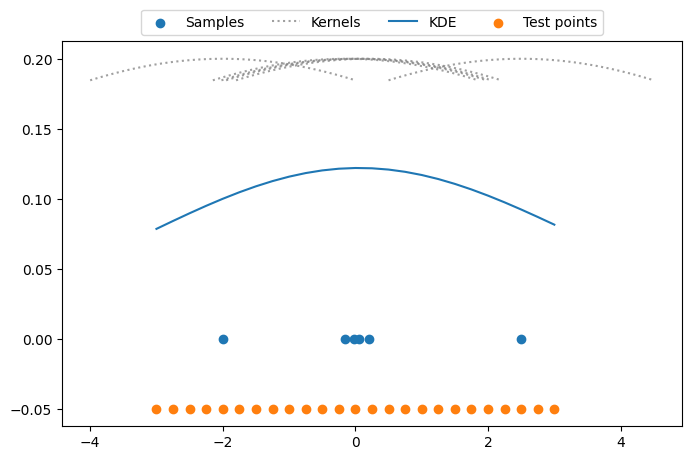

In [15]:
x_vals = [-2, -0.15, -0.02, 0.05, 0.2, 2.5]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x_vals, np.zeros_like(x_vals), label='Samples')

h = 5.
window = np.linspace(-2., 2.) 
for i, x in enumerate(x_vals):
    if i == 0:
        ax.plot(x+window, np.exp(-0.5*(window/h)**2)/h, alpha=0.75, linestyle=":", color='grey', label="Kernels")
    else:
        ax.plot(x+window, np.exp(-0.5*(window/h)**2)/h, alpha=0.75, linestyle=":", color='grey')
    
test_points = np.linspace(-3, 3, 25)[:, np.newaxis]
kde = kernel_density(np.array(x_vals)[:, np.newaxis], test_points, 3.0)
ax.plot(test_points, kde, label="KDE")
ax.scatter(test_points, -0.05*np.ones_like(test_points), label="Test points")
ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1),)

However, all is not lost as we can vary the bandwidth parameter to get closer to the target distribution.

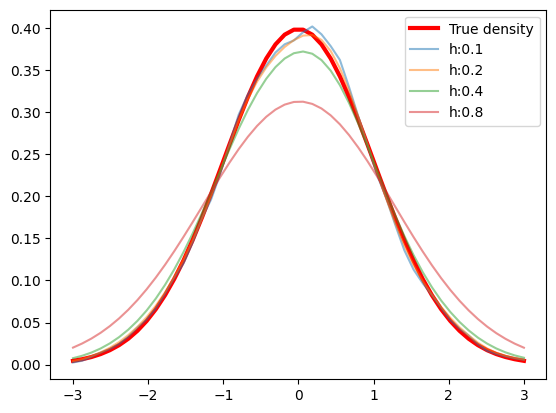

In [16]:
hh = [0.1, 0.2, 0.4, 0.8]
n_train = 10000
x_test = np.linspace(-3., 3.)[:, np.newaxis]
true_density = stats.norm(0,1).pdf(x_test)
Xtrain = stats.norm(0, 1).rvs(size=n_train)[:, np.newaxis]
all_estimates = {str(h): np.zeros((len(x_test),)) for h in hh}

fig, ax = plt.subplots()
ax.plot(x_test, true_density, lw=3., color='red', label="True density")
for i, h in enumerate(hh):
    estimate = kernel_density(Xtrain, x_test, h)
    ax.plot(x_test, estimate, alpha=0.5, color="C"+str(i), label=f"h:{h}")
ax.legend()



It turns out that if we define the bandwidth as a function of $n$, say $h = h(n)$, then provided the sample 
size $n$ grows more quickly than $h(n)$ decays, the kernel density estimate will converge
pointwise to the density function evaluated at that point.
A stronger form of  convergence (known as uniform convergence) can be obtained if $n$ grows faster than the square of $h(n)$.
If the number of samples $n$ in the training set grows more 
For example, if we guarantee that the band
$\lim_{n \rightarrow \infty}n h_n = \infty$, then uniform convergence to the distribution is obtained.

<!-- It looks as if the density estimate is converging to some consistent level of error.  This is the unresolvable model error.
Some further sources can be found at:
- https://www.projectrhea.org/rhea/images/4/4c/Parzen_window_method_and_classification.pdf
- https://www.ehu.eus/ccwintco/uploads/8/89/Borja-Parzen-windows.pdf -->

We will now show that allowing the bandwidth to decay with $n$ causes the KDE to converge to the true distribution.
We use a uniform grid over $[-2, 2]$ as the test set.

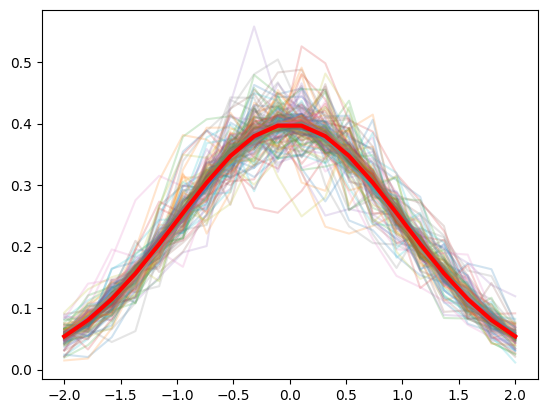

In [17]:
num_trials = 10
query = np.linspace(-2., 2., num=20)[:, np.newaxis]
true_dist = stats.norm(0,1).pdf(query)
nn = np.logspace(2, 7, endpoint=False, dtype=np.int64, num=20) 

kernel_errors = {i:np.zeros((len(nn),), dtype=float) for i in range(num_trials)}
#conv_estimates = {i:np.zeros((len(nn),), dtype=float) for i in range(num_trials)}

fig, ax = plt.subplots()
for i,n in enumerate(nn):
    for t in range(num_trials):
        Xtrain = stats.norm(0, 1).rvs(size=n)[:, np.newaxis]
        estimate = kernel_density(Xtrain, query, 2./n**0.5)
        error = np.linalg.norm(estimate.flatten() - true_dist.flatten())
        kernel_errors[t][i] = error
        ax.plot(query, estimate, alpha=0.2)
        
ax.plot(query, true_dist, lw=3., color='red')

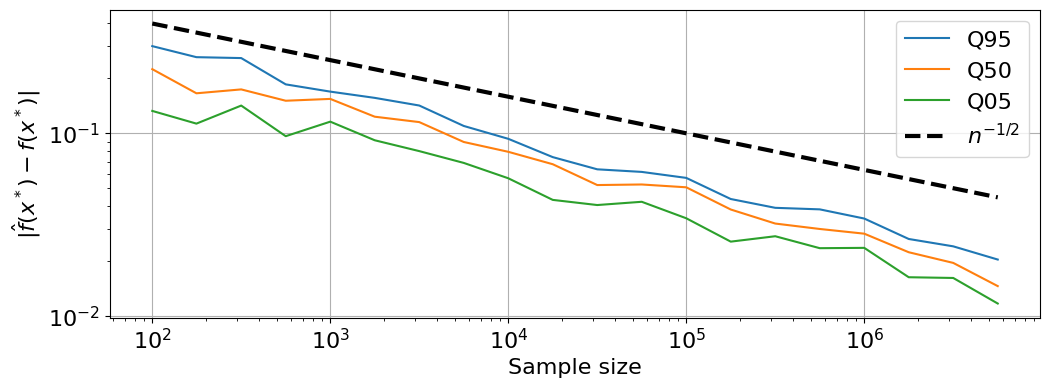

In [18]:
dist_df = pd.DataFrame.from_dict(kernel_errors)

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(nn, dist_df.quantile(q=0.95,axis=1), label='Q95')
ax.plot(nn, dist_df.quantile(q=0.5, axis=1), label="Q50")
ax.plot(nn, dist_df.quantile(q=0.05,axis=1), label='Q05')
ax.plot(nn, (nn)**(-0.2), linestyle='--', color='black', linewidth=3.0, label=r"$n^{-1/2}$")
#ax.plot(nn, (1/16)*(nn)**(-0.5),  linestyle='--', color='black', linewidth=3.0, label=r"$\frac{1}{16}n^{-1/2}$")
ax.set_ylabel(r"$|\hat{f}(x^*) - f(x^*)|$")
ax.set_xlabel(r"Sample size")
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title=r"$h_n = 2n^{-0.2}$")
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.get_label().set_fontsize(16)
ax.yaxis.get_label().set_fontsize(16)
ax.legend(prop={'size': 16})

Setting the bandwidth parameter $h_n \approx n^{-0.5}$ means that the number of samples grows faster than the rate at which $h_n$ shrinks.  This setting shows that convergence to the true distribution is achieved over the entire input domain.  

## 4. Using a Kernel Density Estimator

### 4.1 Distribution Visualisation

A canonical use-case is to use the KDE for brief simple visualization tasks.  Here, we might be interested in simple univariate or bivariate distributions.  For example, below we have a simple Gaussian Mixture Model (a modification of the [scikit-learn](https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html) tutorial).

In [19]:
N = 10000
np.random.seed(1)

lw= 3.
left_mass_param = 0.3
right_mass_param = 1. - left_mass_param
X_train = np.concatenate(
    (np.random.normal(0, 1, int(left_mass_param * N)), 
     np.random.normal(5, 1, int(right_mass_param * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis] # Linearly spaced points on the interval.

################ True density function ################
true_dens = left_mass_param * stats.norm(0, 1).pdf(X_plot[:, 0]) + right_mass_param * stats.norm(5, 1).pdf(X_plot[:, 0])

In [20]:
def make_basic_plot():
    fig, ax = plt.subplots(figsize=(16,8))
    ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
    lw = 2

    ax.legend(loc="upper left", title="N={0} points".format(N))
    ax.plot(X_train[:, 0], -0.005 - 0.01 * np.random.random(X_train.shape[0]), "+k", alpha=0.1, label='samples')

    ax.set_xlim(-4, 9)
    return fig, ax

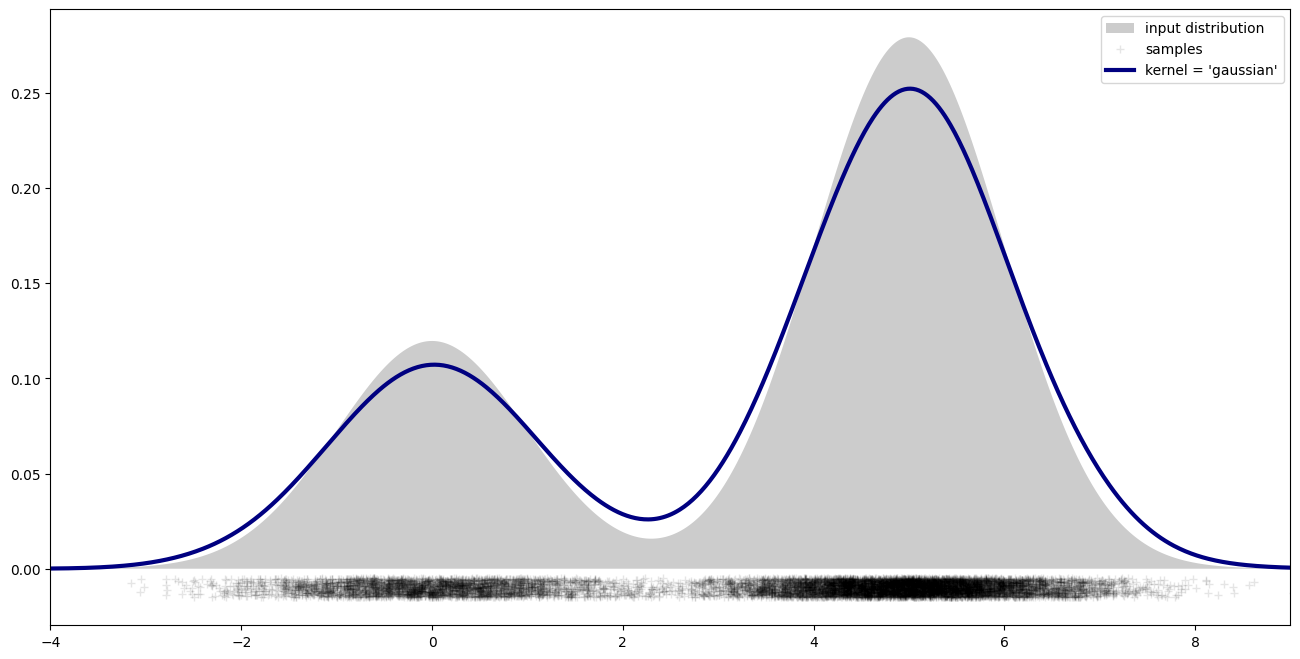

In [21]:
################ KDE functions ################
colors = ["navy"]
kernels = ["gaussian"]
fig, ax = make_basic_plot()
for color, kernel in zip(colors, kernels):
    kde = kernel_density(X_train, X_plot, 0.5) 
    ax.plot(
        X_plot[:, 0],
        kde,
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )
ax.legend()

We can also plot bivariate examples such as a 2d Gaussian distribution.  The next cell generates a bivariate Gaussian distribution.

In [40]:
x = np.linspace(-3, 3)
y = np.linspace(-3, 3)

X_test, Y_test = np.meshgrid(x, y)
X_plot = np.c_[X_test.ravel(), Y_test.ravel()]

# Generate input distribution
means = [0, 0]
covariances = np.array([[1., 0.4],
               [0.8, 1.]])
mvn = stats.multivariate_normal(mean=means, cov=covariances)
X_train = mvn.rvs(size=10000)
dist = mvn.pdf(X_plot)

Text(0.5, 1.0, 'Samples from Bivariate Normal')

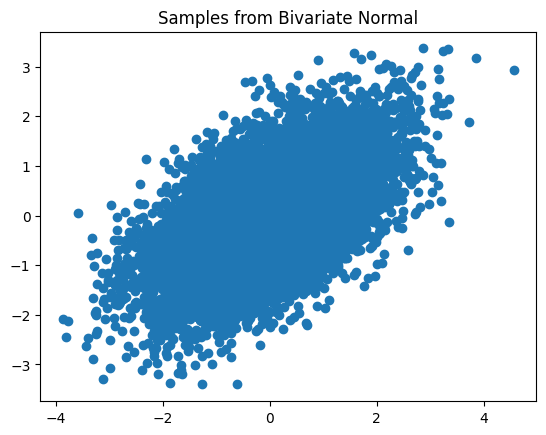

In [23]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.title("Samples from Bivariate Normal")

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_20006/3788610756.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_both.set_yticklabels(ylabels)
/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_20006/3788610756.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_both.set_xticklabels(ylabels)


Text(0.5, 0.98, 'True Distribution')

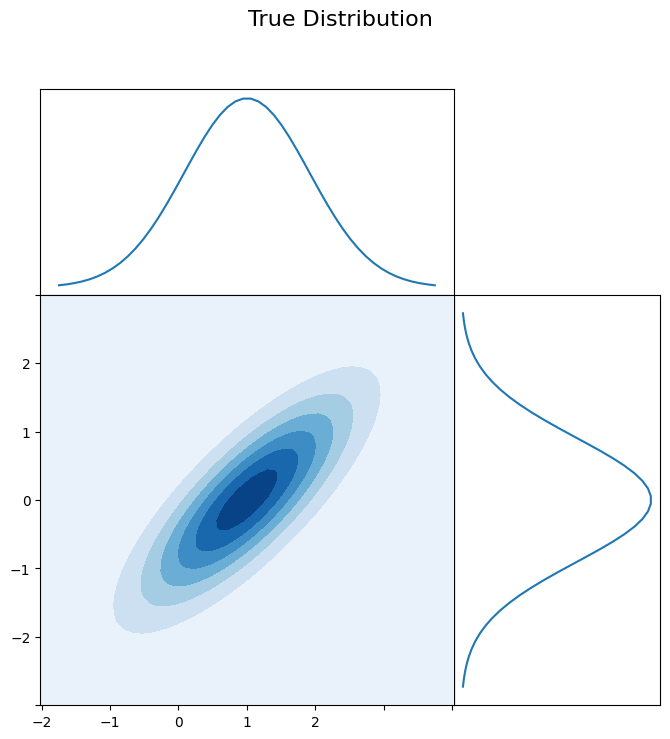

In [24]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)

ax_component1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax_component2 = plt.subplot2grid(shape=(3, 3), loc=(1, 2), rowspan=2)
ax_both = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
 
# plotting both Gaussian components
ax_component1.plot(x, stats.multivariate_normal.pdf(x, mean=means[0], cov=covariances[0][0]))
ax_component2.plot( stats.multivariate_normal.pdf(x, mean=means[1], cov=covariances[1][1]), x)


ax_both.contourf(X_test, Y_test, dist.reshape(X_test.shape), cmap="Blues")
#ax_both.contour(X_train[:,0], X_train[:,1], dist)
#ax_both.scatter(X_train[:,0], X_train[:,1],alpha=0.1, marker='.')

 
plt.subplots_adjust(wspace=0, hspace=0)
ax_both.axis('equal')

for a in [ax_component1, ax_component2]:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)

plt.gcf().canvas.draw()
ylabels = ax_both.get_yticklabels()
ylabels[0] = ylabels[-1] = ""
ax_both.set_yticklabels(ylabels)
#ax_both.scatter(X_test, Y_test, alpha=0.2)
xlabels = ax_both.get_xticklabels()
xlabels[0] = xlabels[-1] = ""
ax_both.set_xticklabels(ylabels)
fig.suptitle('True Distribution', fontsize=16)

Now, let's plot the KDE evaluated over the same test grid.

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_20006/3462036152.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_both.set_yticklabels(ylabels)
/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_20006/3462036152.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_both.set_xticklabels(ylabels)


Text(0.5, 0.98, 'Kernel Density Estimate')

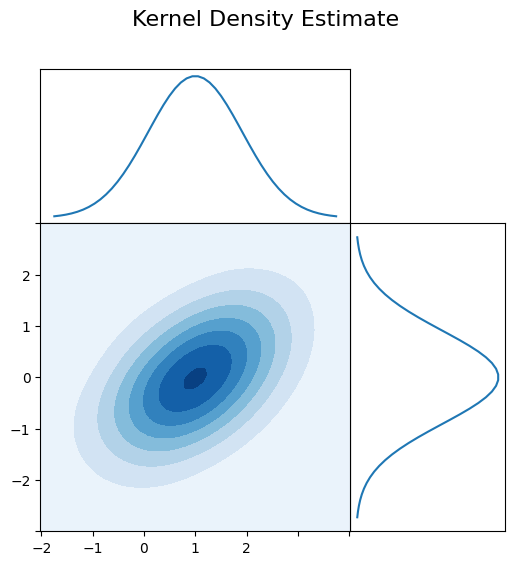

In [25]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(6)

ax_component1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax_component2 = plt.subplot2grid(shape=(3, 3), loc=(1, 2), rowspan=2)
ax_both = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
 
# plotting both Gaussian components
ax_component1.plot(x, stats.multivariate_normal.pdf(x, mean=means[0], cov=covariances[0][0]))
ax_component2.plot( stats.multivariate_normal.pdf(x, mean=means[1], cov=covariances[1][1]), x)


# Fit and plot the model
kde =  kernel_density(X_train, X_plot, 0.5).reshape(X_test.shape)
ax_both.contourf(X_test, Y_test, kde, cmap="Blues")

plt.subplots_adjust(wspace=0, hspace=0)
ax_both.axis('equal')

for a in [ax_component1, ax_component2]:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)

#plt.gcf().canvas.draw()
ylabels = ax_both.get_yticklabels()
ylabels[0] = ylabels[-1] = ""
ax_both.set_yticklabels(ylabels)
xlabels = ax_both.get_xticklabels()
xlabels[0] = xlabels[-1] = ""
ax_both.set_xticklabels(ylabels)
fig.suptitle('Kernel Density Estimate', fontsize=16)

Plot the two side by side.

Text(0.5, 1.0, 'KDE')

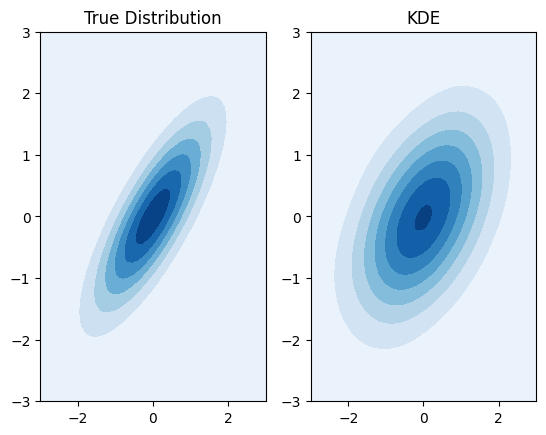

In [26]:
fig, ax = plt.subplots(ncols=2)
ax[0].contourf(X_test, Y_test, dist.reshape(X_test.shape), cmap="Blues")
ax[1].contourf(X_test, Y_test, kde, cmap="Blues")
ax[0].set_title("True Distribution")
ax[1].set_title("KDE")

In practice, we may never have the true distribution for comparison.  Instead, the user should vary the bandwidth and compare against some other held out data from their dataset to choose the best bandwidth.
An example of this approach on real data can be seen on the classical _iris_ dataset.
We choose the first two features which are `sepal_length` and `sepal_width`, respectively.

In [27]:
from sklearn.datasets import load_iris

In [28]:
iris = load_iris()
X_iris = iris.data[:, :2]
y_iris = iris.target

Text(0, 0.5, 'Sepal width')

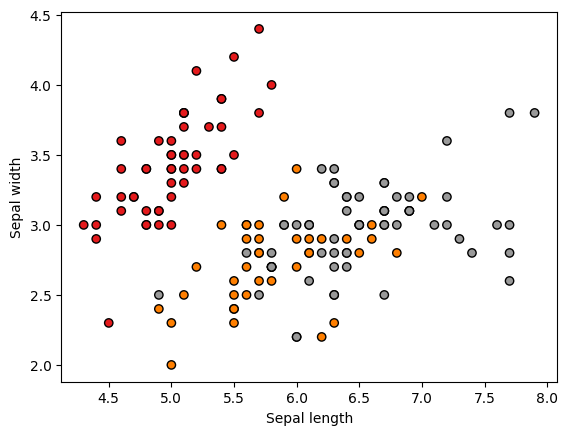

In [29]:
# Plot the training points
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

The plotted contours represent the kernel density estimates.  The estimates in one dimension are also plotted.

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_20006/975648639.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_both.set_yticklabels(ylabels)
/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_20006/975648639.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_both.set_xticklabels(ylabels)


Text(0.5, 0.98, 'Kernel Density Estimate')

<Figure size 640x480 with 0 Axes>

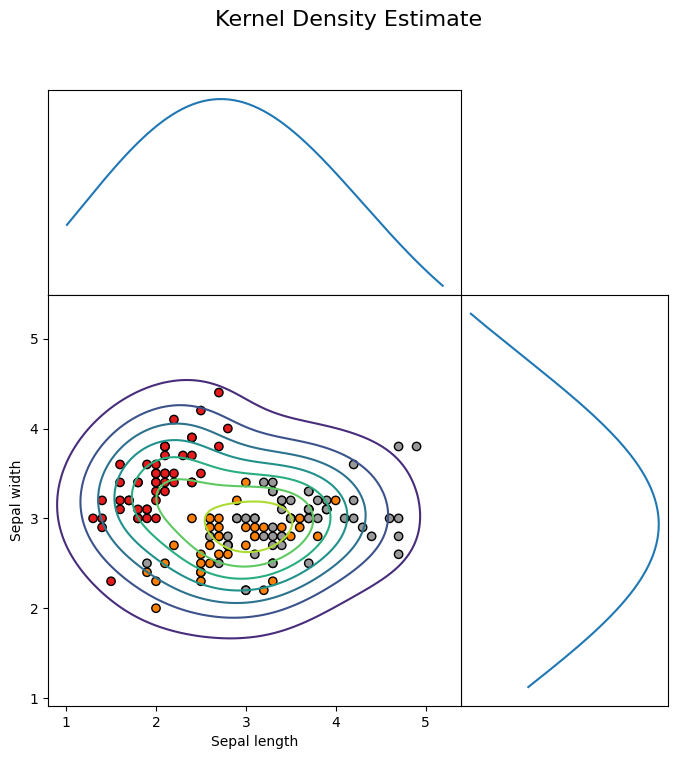

In [30]:
plt.clf()
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)

ax_component1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax_component2 = plt.subplot2grid(shape=(3, 3), loc=(1, 2), rowspan=2)
ax_both = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
 
# first_kde
first_x = np.linspace(X_iris[:,0].min(), X_iris[:,0].max(), num=len(X_iris))[:, np.newaxis]
first_kde = kernel_density(X_iris[:,0][:, np.newaxis], first_x) 
ax_component1.plot(first_x, first_kde)

# Second kde
second_x = np.linspace(X_iris[:,1].min(), X_iris[:,1].max(), num=len(X_iris))[:, np.newaxis]
second_kde = kernel_density(X_iris[:,1][:, np.newaxis], second_x) 
ax_component2.plot(second_kde,second_x)


# Fit and plot the model
buffer = 0.5
x = np.linspace(X_iris[:,0].min()-buffer, X_iris[:,0].max()+buffer, 100)
y = np.linspace(X_iris[:,1].min()-buffer, X_iris[:,1].max()+buffer, 100)
X_test, Y_test = np.meshgrid(x, y)
X_plot = np.c_[X_test.ravel(), Y_test.ravel()]
ests = kernel_density(X_iris, X_plot, 0.5).reshape(X_test.shape)
ax_both.contour(X_test, Y_test, ests)
ax_both.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap=plt.cm.Set1, edgecolor="k")
ax_both.set_xlabel("Sepal length")
ax_both.set_ylabel("Sepal width")

# automatically adjust padding horizontally as well as vertically.
plt.subplots_adjust(wspace=0, hspace=0)
ax_both.axis('equal')

for a in [ax_component1, ax_component2]:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)

plt.gcf().canvas.draw()
ylabels = ax_both.get_yticklabels()
ylabels[0] = ylabels[-1] = ""
ax_both.set_yticklabels(ylabels)
xlabels = ax_both.get_xticklabels()
xlabels[0] = xlabels[-1] = ""
ax_both.set_xticklabels(ylabels)
fig.suptitle('Kernel Density Estimate', fontsize=16)

## 5. The Shape of Things to Come: Coresets

One problem with the KDE method, is that the ``test`` time is high.
For every query point the user provides, the query must evaluate $\frac1n \sum_{i=1}^n K(x - x^*)$.
This sum is a sum over $n$ length $d$ vectors so costs $O(nd)$ time  to return the estimate.  In addition, $O(n)$ space is required for any query since the entire dataset is needed.  Clearly, for a large dataset, this is not a feasible solution so we need a more scalable method.  

The method that we have developed is called a _coreset_ - a specially chosen weighted subset of the data.  The coreset should be a small representation of the entire dataset for the kernel query.

The idea is tha a query on test point $x^*$
\begin{align}
q^* = \frac1n \sum_{i=1}^n K(x^* - x_i)
\end{align}
should be well approximated by evaluating the kernel on the weight-point pairs $(w_i, v_i)$:
\begin{align}
\hat{q} = \frac1m \sum_{i=1}^m K(x^* - w_i v_i)
\end{align}

In [31]:
from datasketches import density_sketch

We will build a density estimator from the coreset so define a wrapper class.

In [32]:
class CoresetKDE:
    def __init__(self, k_, dim_, bandwidth_=1):
        self.k = k_
        self.dim = dim_
        self.bandwidth = bandwidth_
        self.normalisation_factor = np.sqrt(2.)*self.bandwidth
        self.estimation_scale_factor = 1./(np.sqrt(2*np.pi)*self.bandwidth)
        self.sketch = density_sketch(self.k,  self.dim)
    
    def fit(self, X_):
        """Fits the coreset to the data"""
        for x_ in X_:
            self.sketch.update(x_ / self.normalisation_factor)
            
    def predict(self, X):
        """Returns density estimates over array X"""
        predictions = np.zeros((len(X)), dtype=X.dtype)
        for i, x in enumerate(X):
            predictions[i] = self.estimation_scale_factor*self.sketch.get_estimate( x / self.normalisation_factor)
        return predictions
    
    def get_coreset(self):
        """Returns the weighted coreset"""
        samples_weights = [pw for pw in self.sketch]
        samples = np.zeros((self.sketch.get_num_retained(), self.dim))
        weights = np.zeros((self.sketch.get_num_retained(),))
        for i, pw in enumerate(self.sketch):
            samples[i] = pw[0]
            weights[i] = pw[1]
        return samples*self.normalisation_factor, weights

We plot the original dataset in white.  The coreset is smaller than the original input size and also has weights associated to each point.  The weights are indicated by the colorbar.  Only the coloured points are retained by the coreset.

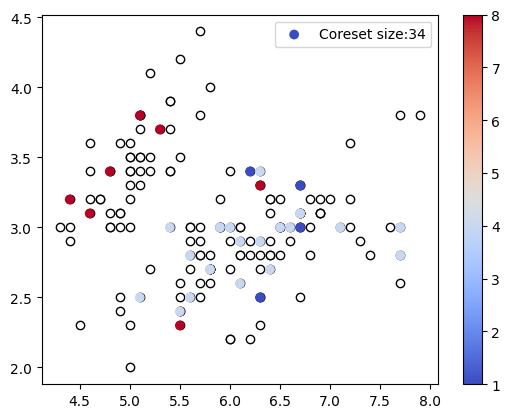

In [33]:
bandwidth = 0.5
c = CoresetKDE(10, 2, bandwidth)
c.fit(X_iris)
coreset_points, coreset_weights = c.get_coreset()

fig, ax = plt.subplots()
ax.scatter(X_iris[:, 0], X_iris[:, 1], c="white", edgecolor="k")
sc = ax.scatter(coreset_points[:, 0], coreset_points[:, 1], 
                c=coreset_weights,cmap="coolwarm", edgecolor=None, label=f"Coreset size:{c.sketch.get_num_retained()}")
plt.colorbar(sc)
ax.legend()

We can visualise the two estimates as follows.  First we defined a test grid over the input domain.  Then we will build a coreset and fit the KDE over the coreset.

In [34]:
buffer = 0.5
x = np.linspace(X_iris[:,0].min()-buffer, X_iris[:,0].max()+buffer, 100)
y = np.linspace(X_iris[:,1].min()-buffer, X_iris[:,1].max()+buffer, 100)
X_test, Y_test = np.meshgrid(x, y)
X_plot = np.c_[X_test.ravel(), Y_test.ravel()]


ests = kernel_density(X_iris, X_plot, bandwidth)
ests = ests.reshape(X_test.shape)
coreset_ests = c.predict(X_plot).reshape(X_test.shape)

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_20006/3989765740.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax_kde.scatter(X_iris[:, 0], X_iris[:, 1], c="white", cmap=plt.cm.Set1, edgecolor="k")


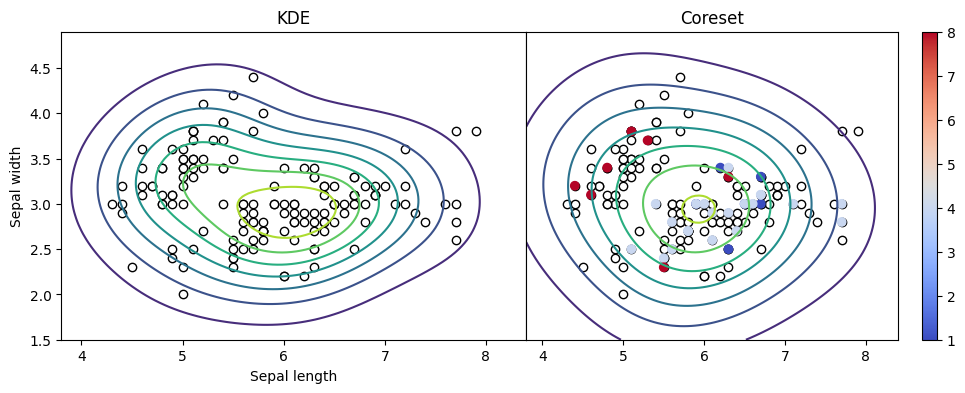

In [35]:
fig, ax = plt.subplots(figsize=(12,4),ncols=2)
ax_kde, ax_coreset = ax
ax_kde.contour(X_test, Y_test, ests)
ax_kde.scatter(X_iris[:, 0], X_iris[:, 1], c="white", cmap=plt.cm.Set1, edgecolor="k")  
ax_coreset.contour(X_test, Y_test, coreset_ests)
ax_coreset.scatter(X_iris[:, 0], X_iris[:, 1], c="white", edgecolor="k")
sc = ax_coreset.scatter(coreset_points[:, 0], coreset_points[:, 1], 
                c=coreset_weights, cmap="coolwarm", edgecolor=None, label=f"Coreset size:{c.sketch.get_num_retained()}")
plt.colorbar(sc)
ax_kde.set_title("KDE")
ax_coreset.set_title("Coreset")
ax_kde.set_xlabel("Sepal length")
ax_kde.set_ylabel("Sepal width")
plt.subplots_adjust(wspace=0, hspace=0)

ax_coreset.get_yaxis().set_visible(False)

### Conclusion

**Objective 1**: To understand exactly what function a kernel density estimate is approximating.

We have seen that the KDE is a function evaluated over a finite sample from a distribution.  
In practice this distribution is likely unknown so the KDE may not have the same scale as the distribution but it should resemble the shape of the distribution.


**Objective 2**: To understand the parameters that affecct the performance of a KDE.

We have seen that the KDE converges quickly to the convolution function when the sample size increases.  
When we know the distribution from which the data is sampled, we can also test how far the convolution form is from the true distribution and we saw that decreasing the bandwidth while increasing the sample size allows the KDE to approach the true distribution.
In practice, we will likely not know the distribution from which a fixed size sample is drawn so the bandwidth parameter must be evaluated to choose the best option.